In [1]:
import cv2 
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, MaxPool2D, Dropout, Flatten, Conv2D

# Collect Data

In [2]:
cap = cv2.VideoCapture(0)
width = int(cap.get(3))
condition = False
counter = 1
mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

rock_list = []
paper_list = []
scissor_list = []

# Here are the file path to store your images
path_rock = r'E:\Python\Learning\DPL302m\Slot\KeoBuaBao\Rock'
path_scissor = r'E:\Python\Learning\DPL302m\Slot\KeoBuaBao\Scissor'
path_paper = r'E:\Python\Learning\DPL302m\Slot\KeoBuaBao\Paper'

# Create a green rectangle to work with
def show_frame():
    global frame, width
    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame,(width-270,0), (width, 250), (0,250,150),2)


# Menu for activate the collect_data function
def menu_button(k): 
    global frame , hand_sign, condition, old_counter, path_rock, path_scissor,path_paper
  
    if k == ord('r'):
        hand_sign = 'rock'
        condition  = not condition
        old_counter = get_total_img(path_rock, hand_sign)
        
    elif k == ord('s'):
        hand_sign = 'scissor'
        condition  = not condition
        old_counter = get_total_img(path_scissor, hand_sign)

    elif k == ord('p'):
        hand_sign = 'paper'
        condition  = not condition
        old_counter = get_total_img(path_paper, hand_sign)


# Check how many images in folder with given type receiving from menu_button function
def get_total_img(path, type):
    my_list = []
    for fn in os.listdir(path):
        name = fn.split('.')[0]
        my_list.append(int(name[len(type):]))
    if len(my_list) > 0 :
        return max(my_list)
    else : return 0


# Function to collect data in rectangle from show_frame
def collect_data():
    global content, hand_sign, frame, counter, condition,width, old_counter, path_rock, path_scissor, path_paper
    
    # Get only 20 pictures for each try
    if counter == 21:
        counter = 1
        condition = not condition

    # Chech wether can save image or not
    if condition:
        new_img = frame[5:245, width-250:width]
        new_counter = int(old_counter + counter) # The index of the new image

        # New image names will look like type{new_counter}
        # Check hand_sign from menu_button to save correctly 
        if hand_sign == 'rock':
            content = 'rock'
            cv2.imwrite(os.path.join(path_rock, f'rock{new_counter}.jpg'), new_img )

        elif hand_sign == 'paper':
            content = 'paper'
            cv2.imwrite(os.path.join(path_paper, f'paper{new_counter}.jpg'), new_img )

        elif hand_sign == 'scissor':
            content = 'scissor'
            cv2.imwrite(os.path.join(path_scissor, f'scissor{new_counter}.jpg'), new_img )

        counter += 1 

        content = f'{hand_sign} are collected {counter}, {old_counter} pics in total'
    else:
        content = 'Type r to Rock, p for paper, s for scissor'

    # Print out what type of data being colleted or the menu line
    frame = cv2.putText(frame, content, (0,400), cv2.FONT_HERSHEY_COMPLEX,
                        0.5,(0,0,255),1, cv2.LINE_8, False)
    



In [3]:
# Code to save your data
cap = cv2.VideoCapture(0)
while True:
    
    ret, frame = cap.read()
    show_frame()

    # Get the input from user
    state = cv2.waitKey(1)

    # Process the input from user
    menu_button(state)
    collect_data()          
    cv2.imshow('frame', frame)
    
    # Check the inpur is q or not, if q break the cam
    if state == ord('q'):
     break

cap.release()
cv2.destroyAllWindows()

# Processing

In [4]:
# Load data from the folder, resize it and append into a list for each type

paper_list = []
# Iterate directory
for file_path in os.listdir(path_paper):
    img_path = os.path.join(path_paper, file_path)
    img =cv2.imread(img_path)
    img = cv2.resize(img, (200,200))
    paper_list.append(img)

rock_list = []
# Iterate directory
for file_path in os.listdir(path_rock):
    img_path = os.path.join(path_rock, file_path)
    img =cv2.imread(img_path)
    img = cv2.resize(img, (200,200))
    rock_list.append(img)

      
scissor_list = []
# Iterate directory
for file_path in os.listdir(path_scissor):
    img_path = os.path.join(path_scissor, file_path)
    img =cv2.imread(img_path)
    img = cv2.resize(img, (200,200))
    scissor_list.append(img)


In [5]:
# Print the len for each list
print(f'Lenght of paper list {len(paper_list)}')
print(f'Lenght of rock list {len(rock_list)}')
print(f'Lenght of scissor list {len(scissor_list)}')

Lenght of paper list 151
Lenght of rock list 127
Lenght of scissor list 180


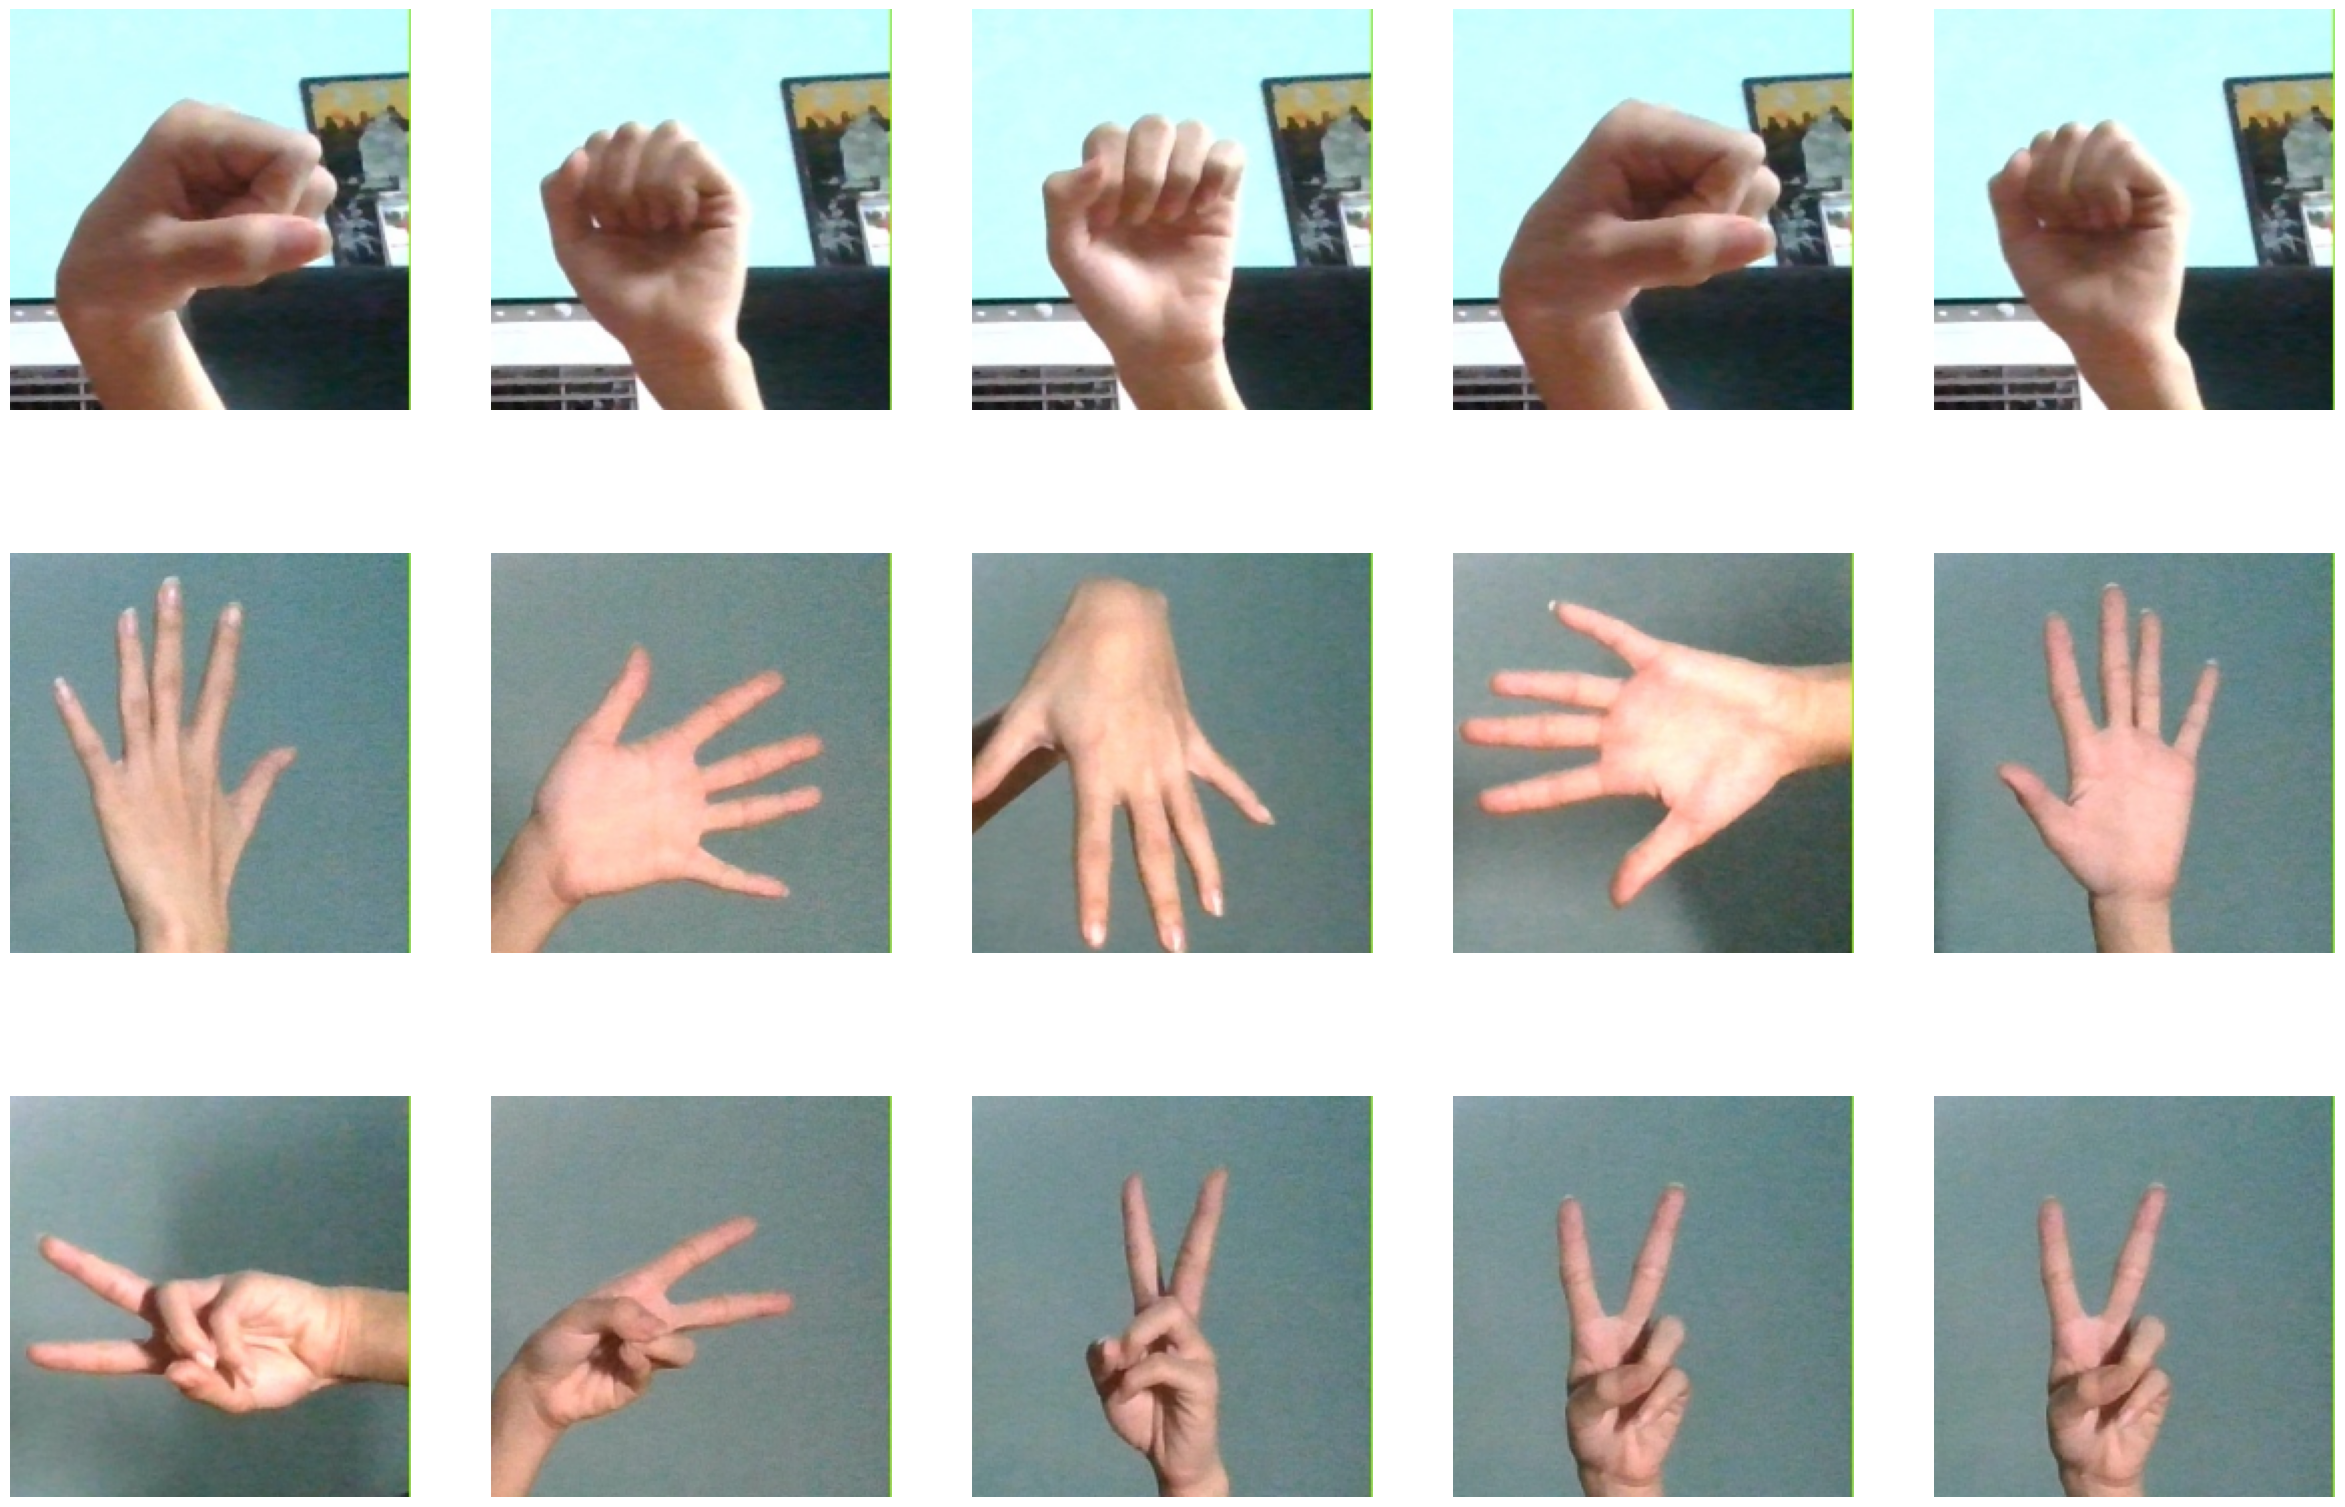

In [ ]:
# Show some randoms images for each type
plt.figure( figsize= [30,20])
count = 1

# Iterate directory
for _, list in enumerate([rock_list, paper_list, scissor_list]):
    index = np.random.randint(100, size=5)
    for img_index in index:
        plt.subplot(3, 5, count)
        count +=  1
        plt.imshow(list[img_index][:,:,::-1])
        plt.axis('off')
        
plt.show()

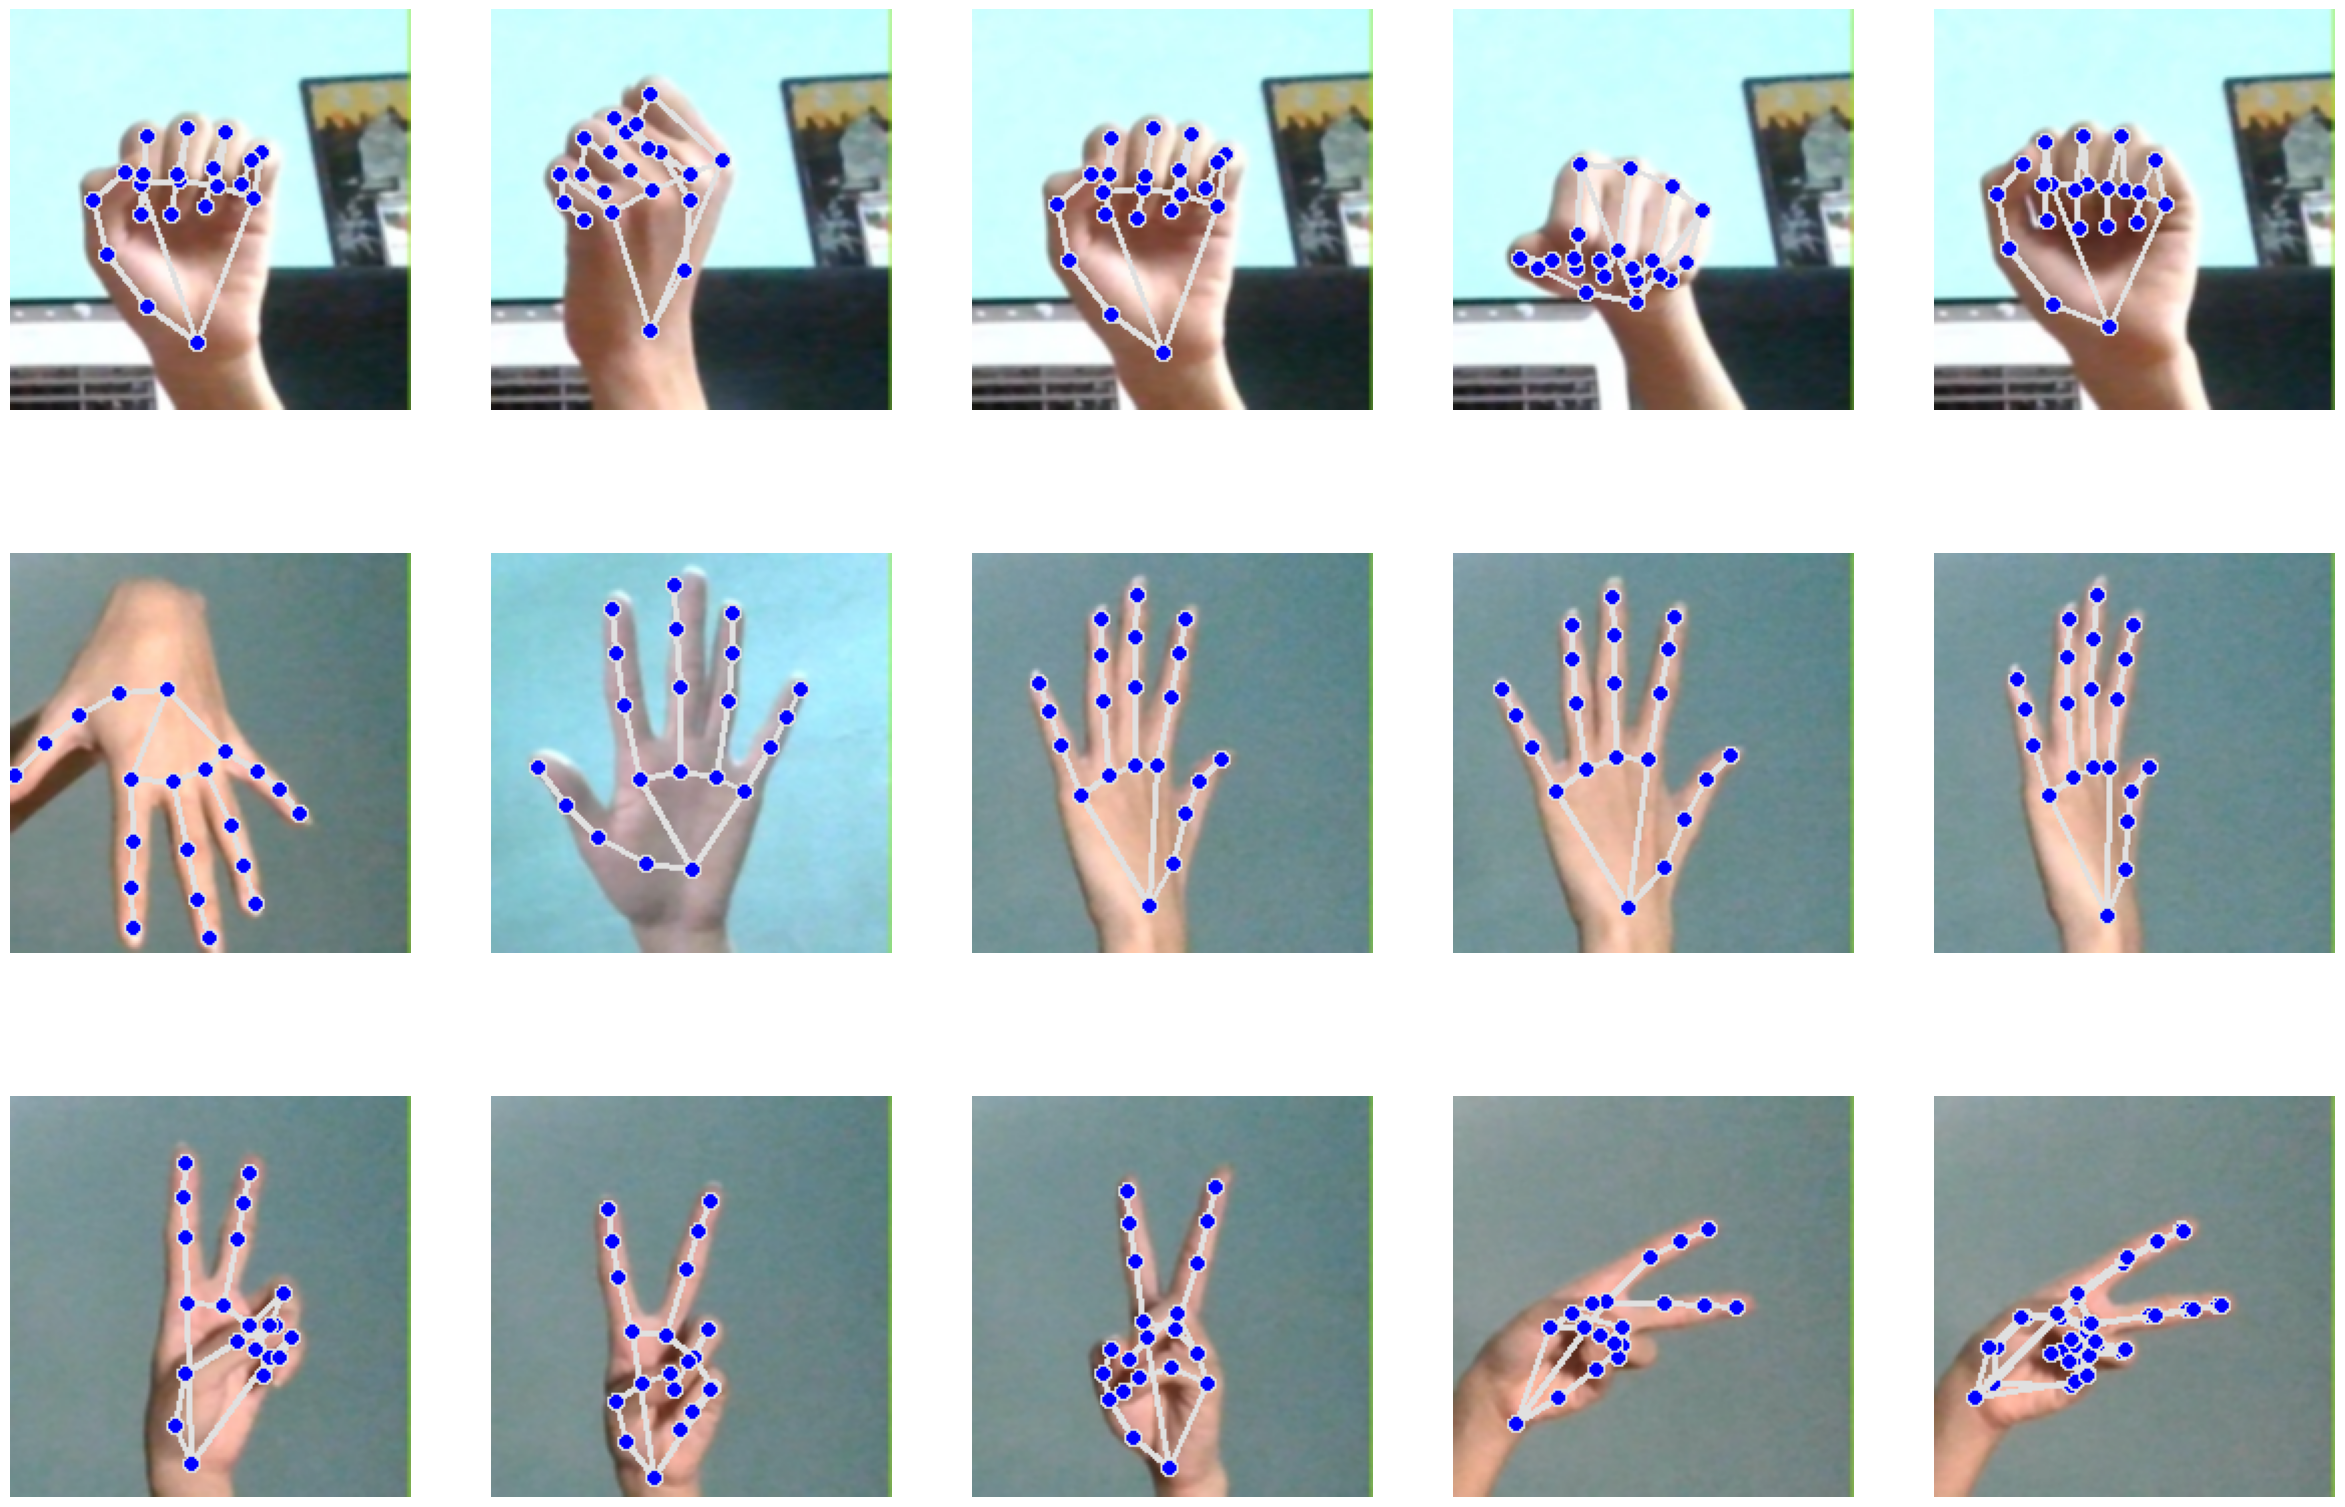

In [14]:
# Show some randoms images for each type and their hand landmarks as well
plt.figure( figsize= [30,20])
count = 1

# Iterate directory
for _, list in enumerate([rock_list, paper_list, scissor_list]):
    index = np.random.randint(min(len(rock_list), len(paper_list), len(scissor_list)), size=5)
    for img_index in index:
        plt.subplot(3, 5, count)
        count +=  1

        # Preprocessing image
        img = list[img_index][:,:,::-1]
        img = cv2.GaussianBlur(img, (3,3), 1)

        # Get hand landmarks form image
        results = hands.process(img)
        
        # Check the result is none or not, if not the image will be pass
        if results.multi_hand_landmarks:
                # Iterate each points in hand landmarks
                for handLms in results.multi_hand_landmarks:
                        for id, lm in enumerate(handLms.landmark):
                                # Draw land marks on the images 
                                mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)
                                plt.imshow(img)
                                plt.axis('off')
                                
plt.show()

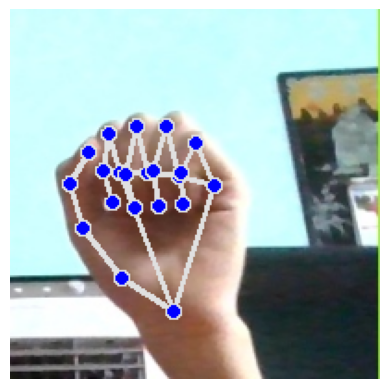

In [ ]:
# Show some images for one type and its hand landmarks as well
# Specify the type and index
new_img = rock_list[55]

# Preprocessing image
new_img = cv2.resize(new_img, (200,200))
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

# Get hand landmarks form image
results = hands.process(new_img)

# Check the result is none or not, if not the image will be pass
if results.multi_hand_landmarks:
        # Iterate each points in hand landmarks
        for handLms in results.multi_hand_landmarks:
            for id, lm in enumerate(handLms.landmark):
                # Draw land marks on the images 
                mpDraw.draw_landmarks(new_img, handLms, mpHands.HAND_CONNECTIONS)
                plt.imshow(new_img)
                plt.axis('off')
plt.show()

In [6]:
# Show the land marks on cam
cap = cv2.VideoCapture(0)
while True:

    # Get frame continously
    ret, frame = cap.read()

    # Preprocessing image
    frame = cv2.flip(frame,1)
    state = cv2.waitKey(1)
    frame = cv2.GaussianBlur(frame, (3,3), 1)
    
    
    # Check the result is none or not, if not the image will be pass
    results = hands.process(frame)
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            # Draw land marks on the images 
            mpDraw.draw_landmarks(frame, handLms, mpHands.HAND_CONNECTIONS)

    cv2.imshow('frame', frame)
    if state == ord('q'):
     break
    
cap.release()
cv2.destroyAllWindows()
                    

In [7]:
# Extract hand landmarks coordinates for each type and save them to list_landmarks

paper_landmarks = []
for item in paper_list:
    item = cv2.cvtColor(item, cv2.COLOR_BGR2RGB)
    results = hands.process(item)
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            paper_landmarks.append(handLms.landmark)

rock_landmarks = []
for item in rock_list:
    item = cv2.cvtColor(item, cv2.COLOR_BGR2RGB)
    results = hands.process(item)
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            rock_landmarks.append(handLms.landmark)

scissor_landmarks = []
for item in scissor_list:
    item = cv2.cvtColor(item, cv2.COLOR_BGR2RGB)
    results = hands.process(item)
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            scissor_landmarks.append(handLms.landmark)
            

In [8]:
# Print the len for each list
print(f'Lenght of paper landmarks {len(paper_landmarks)}')
print(f'Lenght of rock landmarks {len(rock_landmarks)}')
print(f'Lenght of scissor landmarks {len(scissor_landmarks)}')

Lenght of paper landmarks 151
Lenght of rock landmarks 132
Lenght of scissor landmarks 186


In [9]:
# Create X_list for data, Y_list for label
# Label for Rock is 0, Paper is 1, Scissor is 3
# Each point in land marks has 3 dimension x, y, z 
X_list = []
Y_list = []

for mark in rock_landmarks:
    # Add lable
    Y_list.append(0)
    current_list =[]
    for item in mark:
        # Add value from 3 dimension x, y, z 
        current_list.append(item.x)
        current_list.append(item.y)
        current_list.append(item.z)
    # Add value x, y, z to X_list
    X_list.append(current_list)

for mark in paper_landmarks:
    # Add lable
    Y_list.append(1)
    current_list =[]
    for item in mark:
        # Add value from 3 dimension x, y, z 
        current_list.append(item.x)
        current_list.append(item.y)
        current_list.append(item.z)
    # Add value x, y, z to X_list
    X_list.append(current_list)

for mark in scissor_landmarks:
    # Add lable
    Y_list.append(2)
    current_list =[]
    for item in mark:
        # Add value from 3 dimension x, y, z 
        current_list.append(item.x)
        current_list.append(item.y)
        current_list.append(item.z)
    # Add value x, y, z to X_list
    X_list.append(current_list)


In [10]:
# Print the len for each X_list , Y_list
# At this point it must be the same length because it is the total number of the images
print(f'Lenght of X_list {len(X_list)}')
print(f'Lenght of Y_list {len(Y_list)}')

Lenght of X_list 469
Lenght of Y_list 469


In [11]:
# Resahpe X_list so that we can have 63 features based on the x, y, z values
X_list = np.array(X_list, dtype='float')
print(f'Shape of X_list {X_list.shape}')

Shape of X_list (469, 63)


In [12]:
# We use to_categorical to create label to feed in softmax layer
one_hot_labels = to_categorical(Y_list, 3)
one_hot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [13]:
# Split 0.7 data for train and 0.3 for testing 
x_train, x_test, y_train, y_test = train_test_split(X_list,
                                                    one_hot_labels,
                                                    random_state= 42,
                                                    test_size= .3,
                                                    stratify=one_hot_labels # To make sure our train and test data has equal propotion of label
                                                    )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((328, 63), (141, 63), (328, 3), (141, 3))

# Model

In [42]:
# Define model with Dense layers and lr_schedule
model = tf.keras.Sequential([
    keras.layers.Input(shape= (63)),
    keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer=keras.initializers.HeNormal(seed=None)),
    keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer=keras.initializers.HeNormal(seed=None)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units = 3, activation='softmax' )
])


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)


model.compile(loss = 'categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

# See the summary of the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 16)                1024      
                                                                 
 dense_31 (Dense)            (None, 16)                272       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 3)                 51        
                                                                 
Total params: 1,347
Trainable params: 1,347
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Train predifined model
history = model.fit(x_train,
                    y_train,
                    epochs= 50,
                    validation_split= 0.3,
                    verbose= 2)

Epoch 1/50
8/8 - 1s - loss: 1.0807 - accuracy: 0.3537 - val_loss: 1.0681 - val_accuracy: 0.4444 - 995ms/epoch - 124ms/step
Epoch 2/50
8/8 - 0s - loss: 1.0110 - accuracy: 0.4760 - val_loss: 1.0472 - val_accuracy: 0.4343 - 60ms/epoch - 8ms/step
Epoch 3/50
8/8 - 0s - loss: 0.9749 - accuracy: 0.4803 - val_loss: 0.9896 - val_accuracy: 0.6465 - 48ms/epoch - 6ms/step
Epoch 4/50
8/8 - 0s - loss: 0.9136 - accuracy: 0.5153 - val_loss: 0.9367 - val_accuracy: 0.5657 - 80ms/epoch - 10ms/step
Epoch 5/50
8/8 - 0s - loss: 0.8548 - accuracy: 0.6245 - val_loss: 0.8632 - val_accuracy: 0.6465 - 66ms/epoch - 8ms/step
Epoch 6/50
8/8 - 0s - loss: 0.7396 - accuracy: 0.6769 - val_loss: 0.8028 - val_accuracy: 0.7475 - 90ms/epoch - 11ms/step
Epoch 7/50
8/8 - 0s - loss: 0.6815 - accuracy: 0.7424 - val_loss: 0.7614 - val_accuracy: 0.7071 - 100ms/epoch - 13ms/step
Epoch 8/50
8/8 - 0s - loss: 0.6559 - accuracy: 0.7817 - val_loss: 0.6578 - val_accuracy: 0.8081 - 100ms/epoch - 13ms/step
Epoch 9/50
8/8 - 0s - loss: 0.5

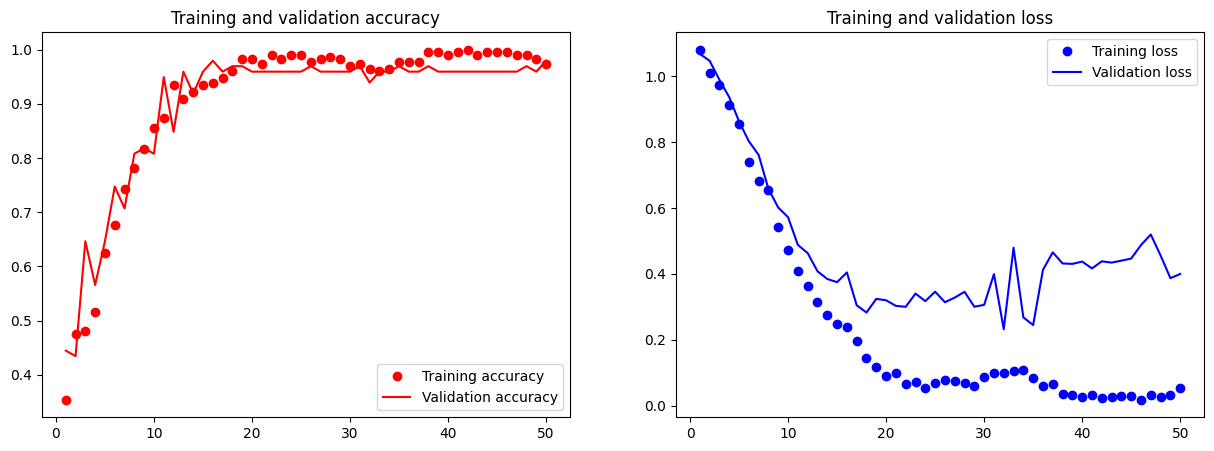

In [44]:
# Displaying curves of loss and accuracy during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [50]:
# Perform predict on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Acc for test data: {test_acc}')
print(f'Los for test data: {test_loss}')

5/5 [==============================] - 0s 3ms/step - loss: 0.1319 - accuracy: 0.9929
Acc for test data: 0.9929078221321106
Los for test data: 0.13190792500972748


In [51]:
# Save model
model.save('base_model.h5')

# Real Time

In [52]:
# Load model
real_model = load_model('base_model.h5')

In [53]:
y_target = ['rock', 'paper', 'scissor', 'nothing']

def show_predict(text):
    global frame
    # Write the prediction in cam
    frame = cv2.putText(frame, text, (0,400), cv2.FONT_HERSHEY_COMPLEX,
                        0.5,(0,0,255),1, cv2.LINE_8, False)

def make_prediction():
    global frame , y_target
    my_list = []
    out_list = []
    target_index = 0
    
    # Get frame and preprocessing
    new_img = frame[5:245, width-250:width]
    new_img = cv2.resize(new_img, (200,200))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    results = hands.process(new_img)

    # Extract hand landmarks coordinates
    if results.multi_hand_landmarks: # Check wether our result is None or not
        for handLms in results.multi_hand_landmarks:
            my_list.append(handLms.landmark)
        for mark in my_list:
            current_list =[]
            for item in mark:
                current_list.append(item.x)
                current_list.append(item.y)
                current_list.append(item.z)
            out_list.append(current_list)
        out_list = np.array(out_list, dtype='float')

        # Perform predict
        pred = real_model.predict(out_list)

        # Get the corresponding label name from the mapping
        target_index =  np.argmax(pred) 

        # Get the corresponding prob from the mapping
        prob = np.max(pred)

        # Check if index is in [0,3]
        if target_index <=3 and target_index >=0:
            # Check if predicted probability is under 0.9
            if prob > 0.85:
                # Display the predicted label and probability on the image
                text =  f'Predict {y_target[target_index]} with {np.round(prob*100)}%'
                show_predict(text)
            else: 
                # Display the nothing label and probability on the image
                text =  f'Predict {y_target[-1]} with {np.round(prob*100)}%'
                show_predict(text)



In [54]:
cap = cv2.VideoCapture(0)

while True:
    
    ret, frame = cap.read()

    show_frame()
    # Get image to predict and print out the results
    make_prediction()
    state = cv2.waitKey(1)
    cv2.imshow('frame', frame)
    
    if state == ord('q'):
     break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step
